In [1]:
import h5py
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import find_peaks, butter, filtfilt, savgol_filter, hilbert
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# ------------------ Paths ------------------ #
phase_folded_path = Path("/Users/rohanmotanavar/Dissertation ECG Parameterization/Pipeline3_Phase_Folding/phase_folded_results.h5")
ptbxl_csv_path = Path("/Users/rohanmotanavar/datasets/PTB_XL/ptbxl_database.csv")
rpeak_csv_path = Path("/Users/rohanmotanavar/Dissertation ECG Parameterization/Pipeline2_R_Peak_detection/rpeak_detection_results.csv")
superclass_csv_path = Path("/Users/rohanmotanavar/datasets/PTB_XL/ptbxl_database_with_superclass.csv")
output_h5_path = Path("PQRST_Complexes_and_Features_final.h5")
output_csv_path = Path("PQRST_Complexes_and_Features_final.csv")

# ------------------ Constants ------------------ #
normalized_length = 400
rpeak_phase = 0.375
fs = 500

# ------------------ Metadata ------------------ #
ptbxl_df = pd.read_csv(ptbxl_csv_path).set_index('ecg_id')
rpeak_df = pd.read_csv(rpeak_csv_path).set_index('ecg_id')
superclass_df = pd.read_csv(superclass_csv_path).set_index('ecg_id')

# ------------------ Helper ------------------ #
def refine_onset_offset_envelope(signal, peak_idx, search_width=40, min_duration=10, env_thresh=0.1):
    n = len(signal)
    start = max(0, peak_idx - search_width)
    end = min(n, peak_idx + search_width)
    analytic = hilbert(signal)
    envelope = np.abs(analytic)
    env = (envelope - np.min(envelope)) / (np.max(envelope) - np.min(envelope) + 1e-8)
    local_env = env[start:end]

    onset, offset = None, None
    for i in range(peak_idx - start - 1, 0, -1):
        if local_env[i] < env_thresh:
            onset = start + i
            break
    for i in range(peak_idx - start + 1, len(local_env)):
        if local_env[i] < env_thresh:
            offset = start + i
            break

    if onset is not None and offset is not None and (offset - onset) < min_duration:
        onset = max(0, peak_idx - min_duration // 2)
        offset = min(n - 1, peak_idx + min_duration // 2)

    return int(onset) if onset is not None else np.nan, int(offset) if offset is not None else np.nan

def refine_t_wave_boundaries(signal, t_peak_idx, search_width=60, min_duration=30, min_gap=20):
    n = len(signal)
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    start = max(0, t_peak_idx - search_width)
    end = min(n, t_peak_idx + search_width)
    local_env = envelope[start:end]
    norm_env = (local_env - np.min(local_env)) / (np.max(local_env) - np.min(local_env) + 1e-8)
    env_thresh = np.min(norm_env) + 0.05 * (np.max(norm_env) - np.min(norm_env))

    t_on_local, t_off_local = None, None
    for i in range(t_peak_idx - start - 1, 0, -1):
        if norm_env[i] < env_thresh:
            t_on_local = i
            break
    for i in range(t_peak_idx - start + 1, len(norm_env)):
        if norm_env[i] < env_thresh:
            t_off_local = i
            break

    t_on = start + t_on_local if t_on_local is not None else np.nan
    t_off = start + t_off_local if t_off_local is not None else np.nan

    if np.isnan(t_on):
        deriv = np.gradient(signal)
        for i in range(t_peak_idx - 1, max(0, t_peak_idx - search_width), -1):
            if deriv[i] < 0 and deriv[i - 1] >= 0:
                t_on = i
                break
    if np.isnan(t_off):
        deriv = np.gradient(signal)
        for i in range(t_peak_idx + 1, min(n, t_peak_idx + search_width)):
            if deriv[i] > 0 and deriv[i - 1] <= 0:
                t_off = i
                break

    if not np.isnan(t_on) and abs(t_peak_idx - t_on) < min_gap:
        t_on = max(0, t_peak_idx - min_gap)
    if not np.isnan(t_off) and abs(t_peak_idx - t_off) < min_gap:
        t_off = min(n - 1, t_peak_idx + min_gap)

    if not np.isnan(t_on) and not np.isnan(t_off) and (t_off - t_on) < min_duration:
        t_on = max(0, t_peak_idx - min_duration // 2)
        t_off = min(n - 1, t_peak_idx + min_duration // 2)

    return int(t_on) if not np.isnan(t_on) else np.nan, int(t_off) if not np.isnan(t_off) else np.nan

# ------------------ Main Loop ------------------ #
csv_rows = []

with h5py.File(phase_folded_path, 'r') as h5_phase, h5py.File(output_h5_path, 'w') as h5_out:
    for ecg_id in tqdm(h5_phase.keys()):
        try:
            ecg_int = int(ecg_id)
            if ecg_int not in ptbxl_df.index or ecg_int not in rpeak_df.index or ecg_int not in superclass_df.index:
                continue

            beat = h5_phase[ecg_id]['representative_beat'][:]
            ptb = ptbxl_df.loc[ecg_int]
            rmeta = rpeak_df.loc[ecg_int]
            supermeta = superclass_df.loc[ecg_int]
            r_idx = int(normalized_length * rpeak_phase)

            # Filter
            b, a = butter(2, [0.5 / (fs / 2), 40 / (fs / 2)], btype='band')
            filt = filtfilt(b, a, beat)
            smooth = savgol_filter(filt, 11, 3)

            # --- Peaks ---
            p_zone = smooth[:r_idx - 20]
            p_peaks, _ = find_peaks(p_zone, prominence=0.01)
            p_peak = p_peaks[-1] if len(p_peaks) else np.nan

            q_peak = r_idx - 15 + np.argmin(smooth[r_idx - 15:r_idx])
            s_peak = r_idx + np.argmin(smooth[r_idx:r_idx + 30])

            t_zone = smooth[s_peak + 10:] if not np.isnan(s_peak) else smooth[r_idx + 30:]
            t_offset_base = s_peak + 10 if not np.isnan(s_peak) else r_idx + 30
            t_peaks, _ = find_peaks(t_zone, prominence=0.01)
            t_peak = t_peaks[0] + t_offset_base if len(t_peaks) else np.nan

            # --- Onsets & Offsets ---
            p_on, p_off = refine_onset_offset_envelope(smooth, int(p_peak)) if not np.isnan(p_peak) else (np.nan, np.nan)
            q_on, _ = refine_onset_offset_envelope(smooth, q_peak) if not np.isnan(q_peak) else (np.nan, np.nan)
            _, s_off = refine_onset_offset_envelope(smooth, s_peak) if not np.isnan(s_peak) else (np.nan, np.nan)
            t_on, t_off = refine_t_wave_boundaries(smooth, int(t_peak)) if not np.isnan(t_peak) else (np.nan, np.nan)

            # --- Clinical Metrics ---
            def time_diff(idx1, idx2): return (idx2 - idx1) / fs * 1000 if not np.isnan(idx1) and not np.isnan(idx2) else np.nan
            def amplitude(idx): return smooth[idx] if not np.isnan(idx) else np.nan

            metrics = {
                'ecg_id': ecg_id,
                'patient_id': ptb['patient_id'],
                'age': ptb['age'],
                'sex': ptb['sex'],
                'filename_hr': ptb['filename_hr'],
                'scp_codes': ptb['scp_codes'],
                'strat_fold': supermeta['strat_fold'],
                'diagnostic_superclass': supermeta['diagnostic_superclass'],
                'diagnostic_single_5_superclass': supermeta['diagnostic_single_5_superclass'],
                'pq_interval_ms': time_diff(p_off, q_peak),
                'pr_interval_ms': time_diff(p_on, r_idx),
                'p_amplitude_mv': amplitude(p_peak),
                'p_duration_ms': time_diff(p_on, p_off),
                'p_biphasic': int(p_on is not np.nan and p_off is not np.nan and np.sign(smooth[int(p_on)]) != np.sign(smooth[int(p_off)])),
                'q_amplitude_mv': amplitude(q_peak),
                'qrs_duration_ms': time_diff(q_on, s_off),
                'qt_interval_ms': time_diff(q_on, t_off),
                'qtc_bazett_ms': time_diff(q_on, t_off) / np.sqrt(60 / rmeta['mean_heart_rate']) if 'mean_heart_rate' in rmeta else np.nan,
                'r_amplitude_mv': amplitude(r_idx),
                's_amplitude_mv': amplitude(s_peak),
                'st_elevation_mv': amplitude(r_idx + 40) - amplitude(s_off) if not np.isnan(s_off) and r_idx + 40 < len(smooth) else np.nan,
                't_amplitude_mv': amplitude(t_peak),
                't_duration_ms': time_diff(t_on, t_off),
                'mean_heart_rate': rmeta.get('mean_heart_rate', np.nan),
                'rr_intervals': rmeta.get('rr_intervals', np.nan),
                'number_of_rpeaks': rmeta.get('number_of_rpeaks', np.nan)
            }

            csv_rows.append(metrics)

            # Save to HDF5
            grp = h5_out.create_group(ecg_id)
            grp.create_dataset('representative_beat', data=beat)
            grp.create_dataset('point_indices', data=np.array([
                ('p_on', p_on), ('p_peak', p_peak), ('p_off', p_off),
                ('q_on', q_on), ('q_peak', q_peak), ('r_peak', r_idx),
                ('s_peak', s_peak), ('s_off', s_off),
                ('t_on', t_on), ('t_peak', t_peak), ('t_off', t_off)
            ], dtype=[('name', 'S10'), ('index', 'f4')]))
            for k, v in metrics.items():
                    grp.attrs[k] = v

        except Exception as e:
            print(f"[ERROR] ECG ID {ecg_id}: {e}")
            continue

# Save to CSV
pd.DataFrame(csv_rows).to_csv(output_csv_path, index=False)
print(f"\n✅ Done! Saved to:\n• HDF5: {output_h5_path}\n• CSV: {output_csv_path}")


100%|██████████| 21799/21799 [00:30<00:00, 719.28it/s]



✅ Done! Saved to:
• HDF5: PQRST_Complexes_and_Features_final.h5
• CSV: PQRST_Complexes_and_Features_final.csv


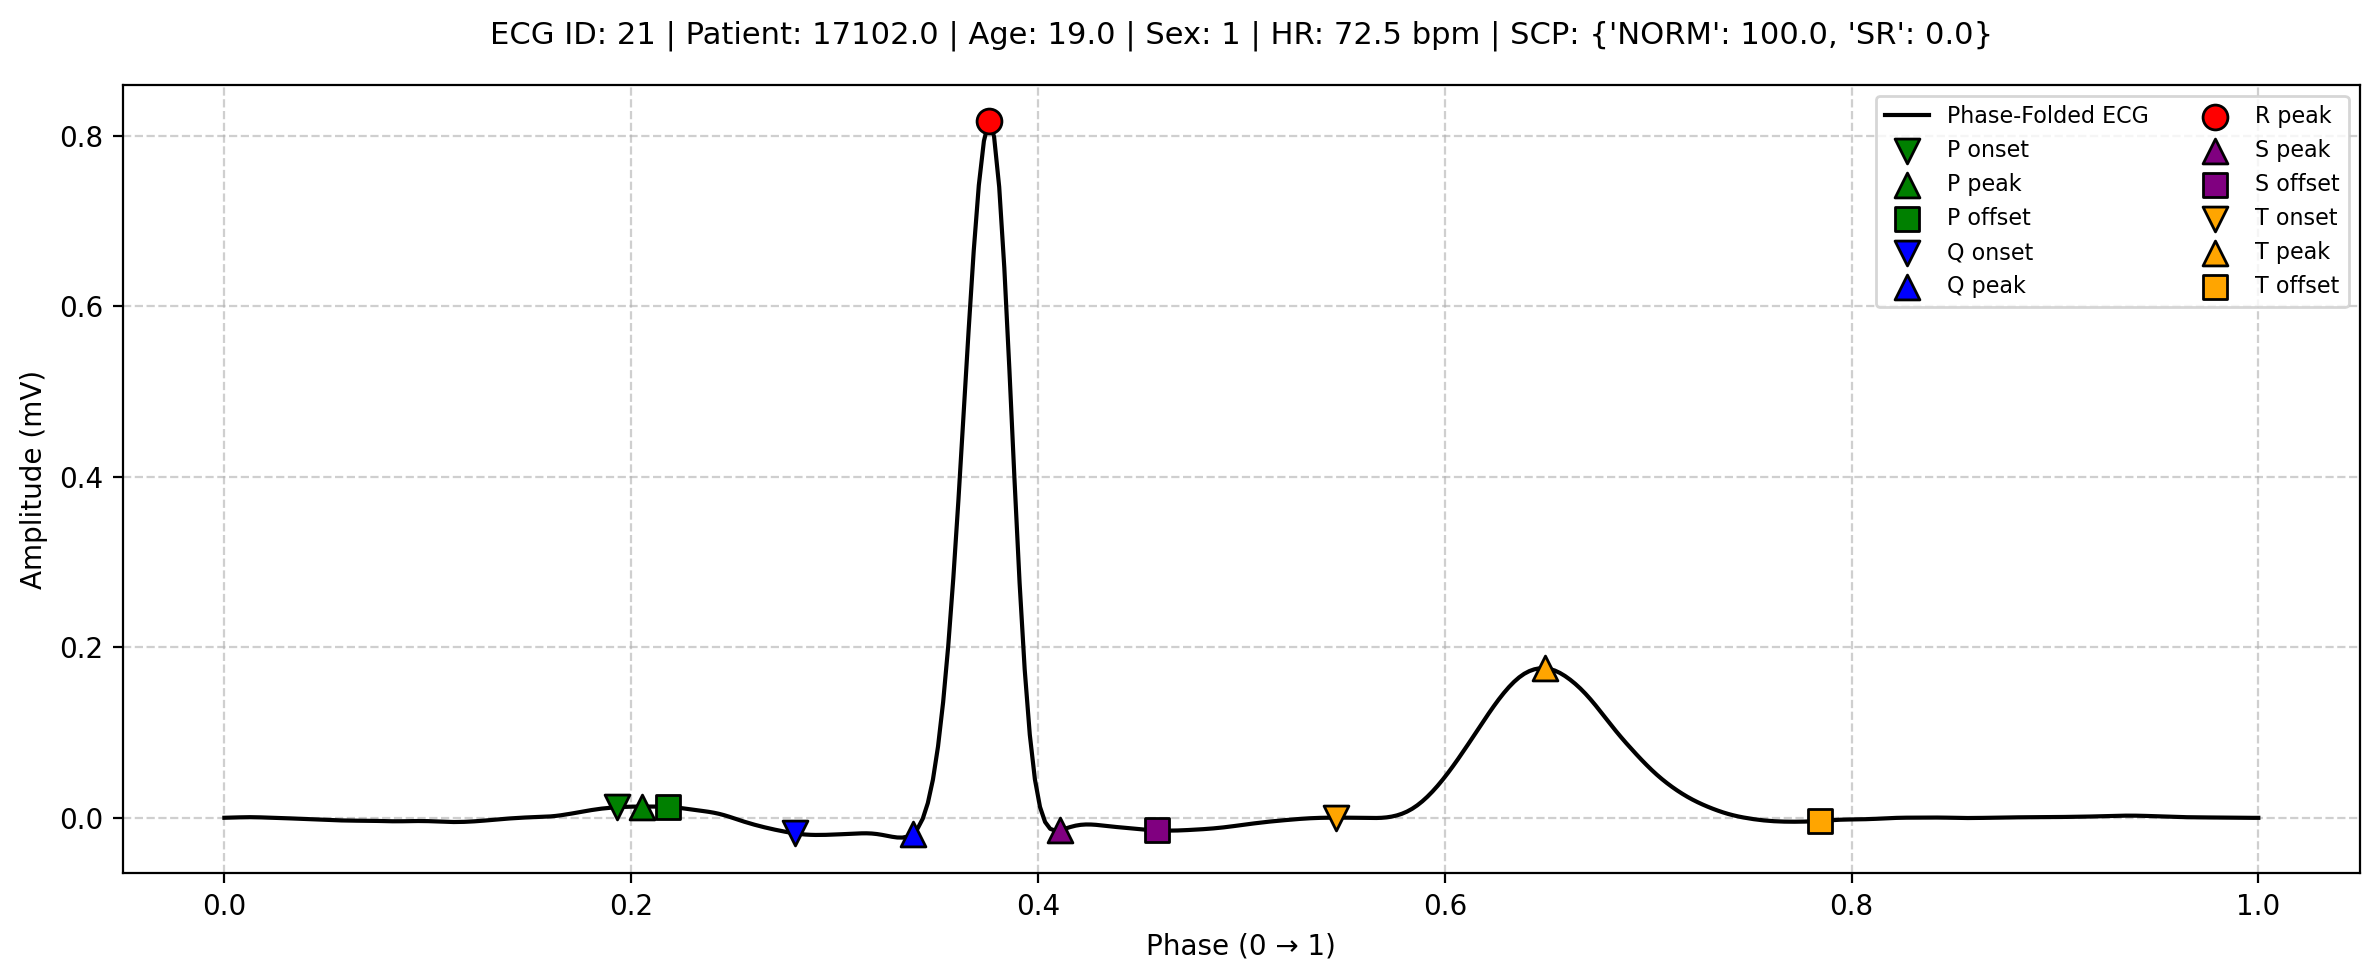

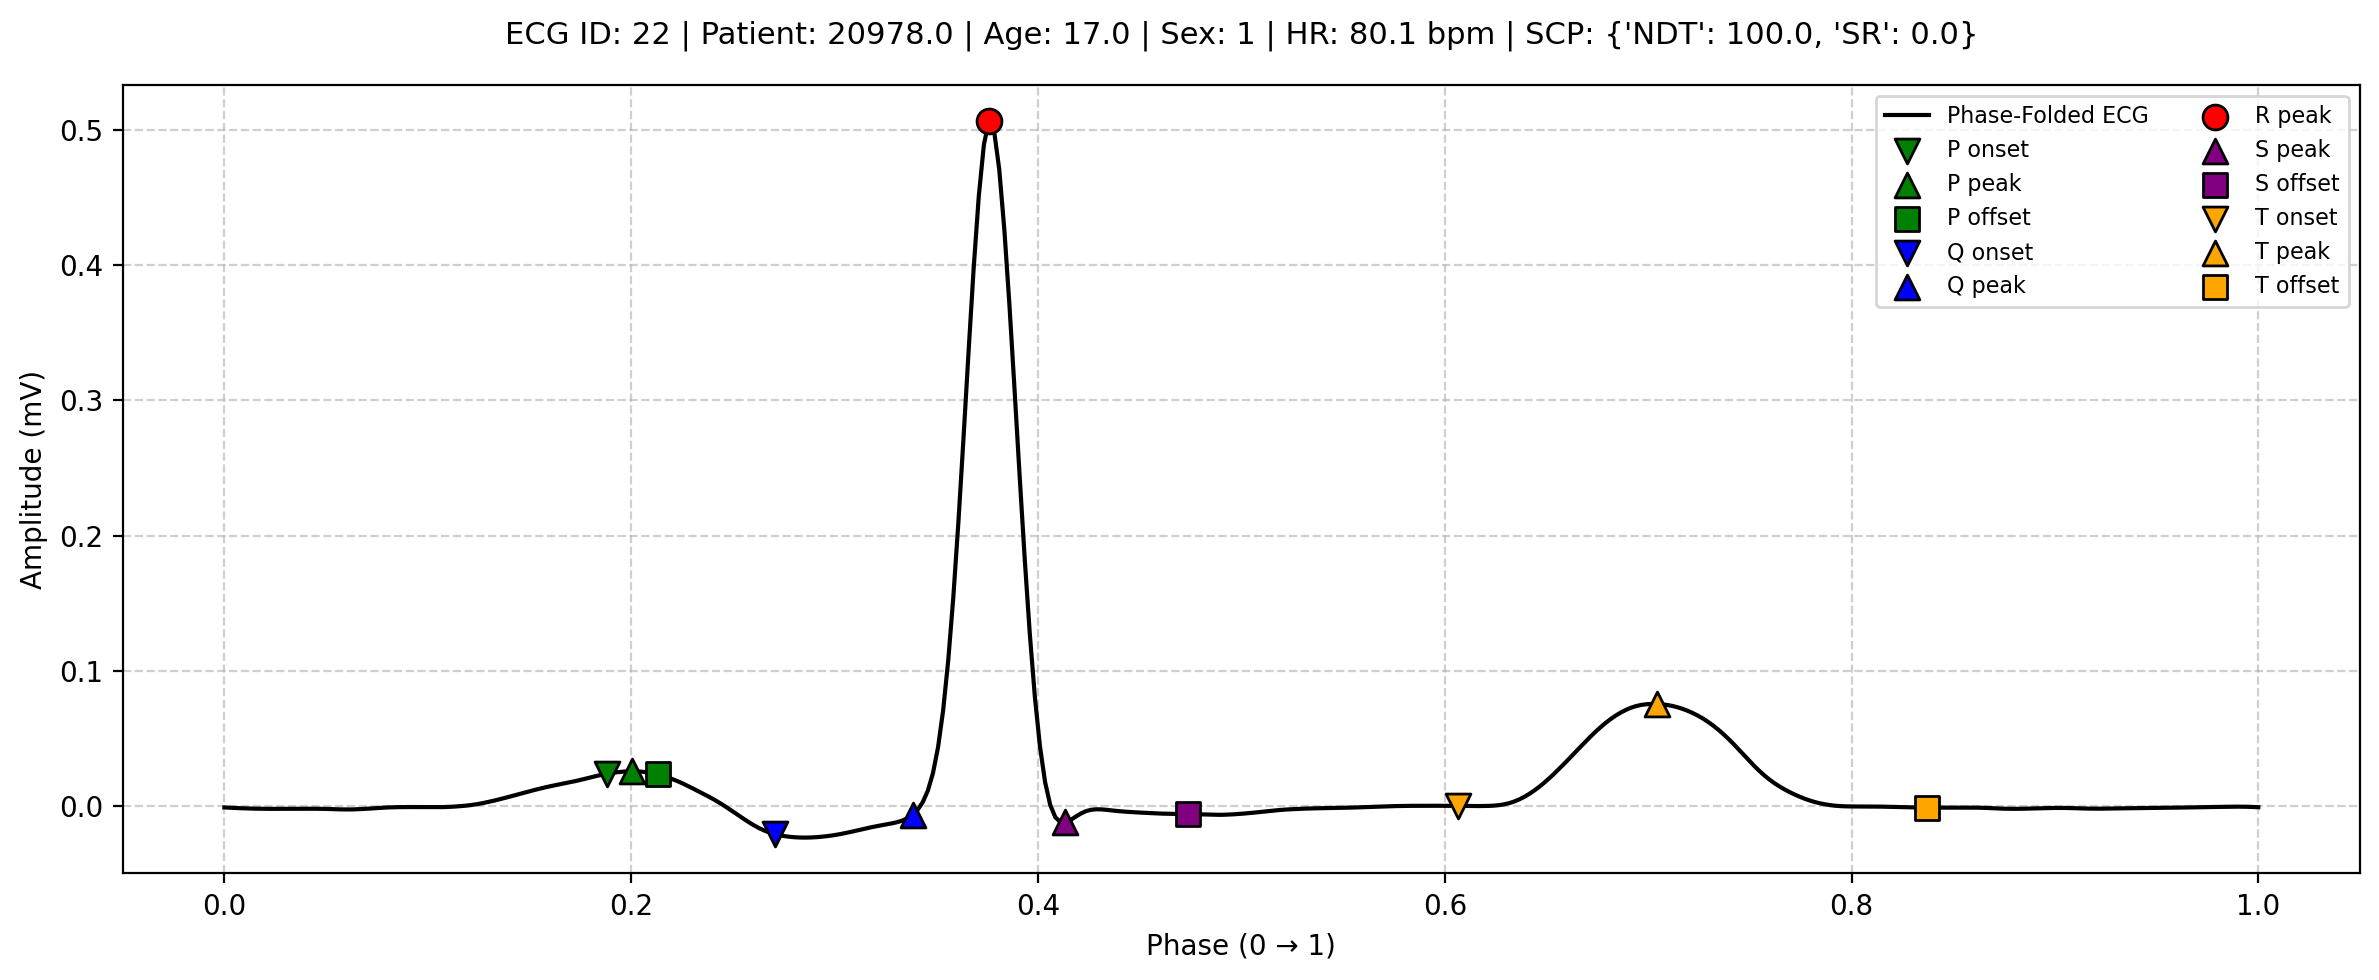

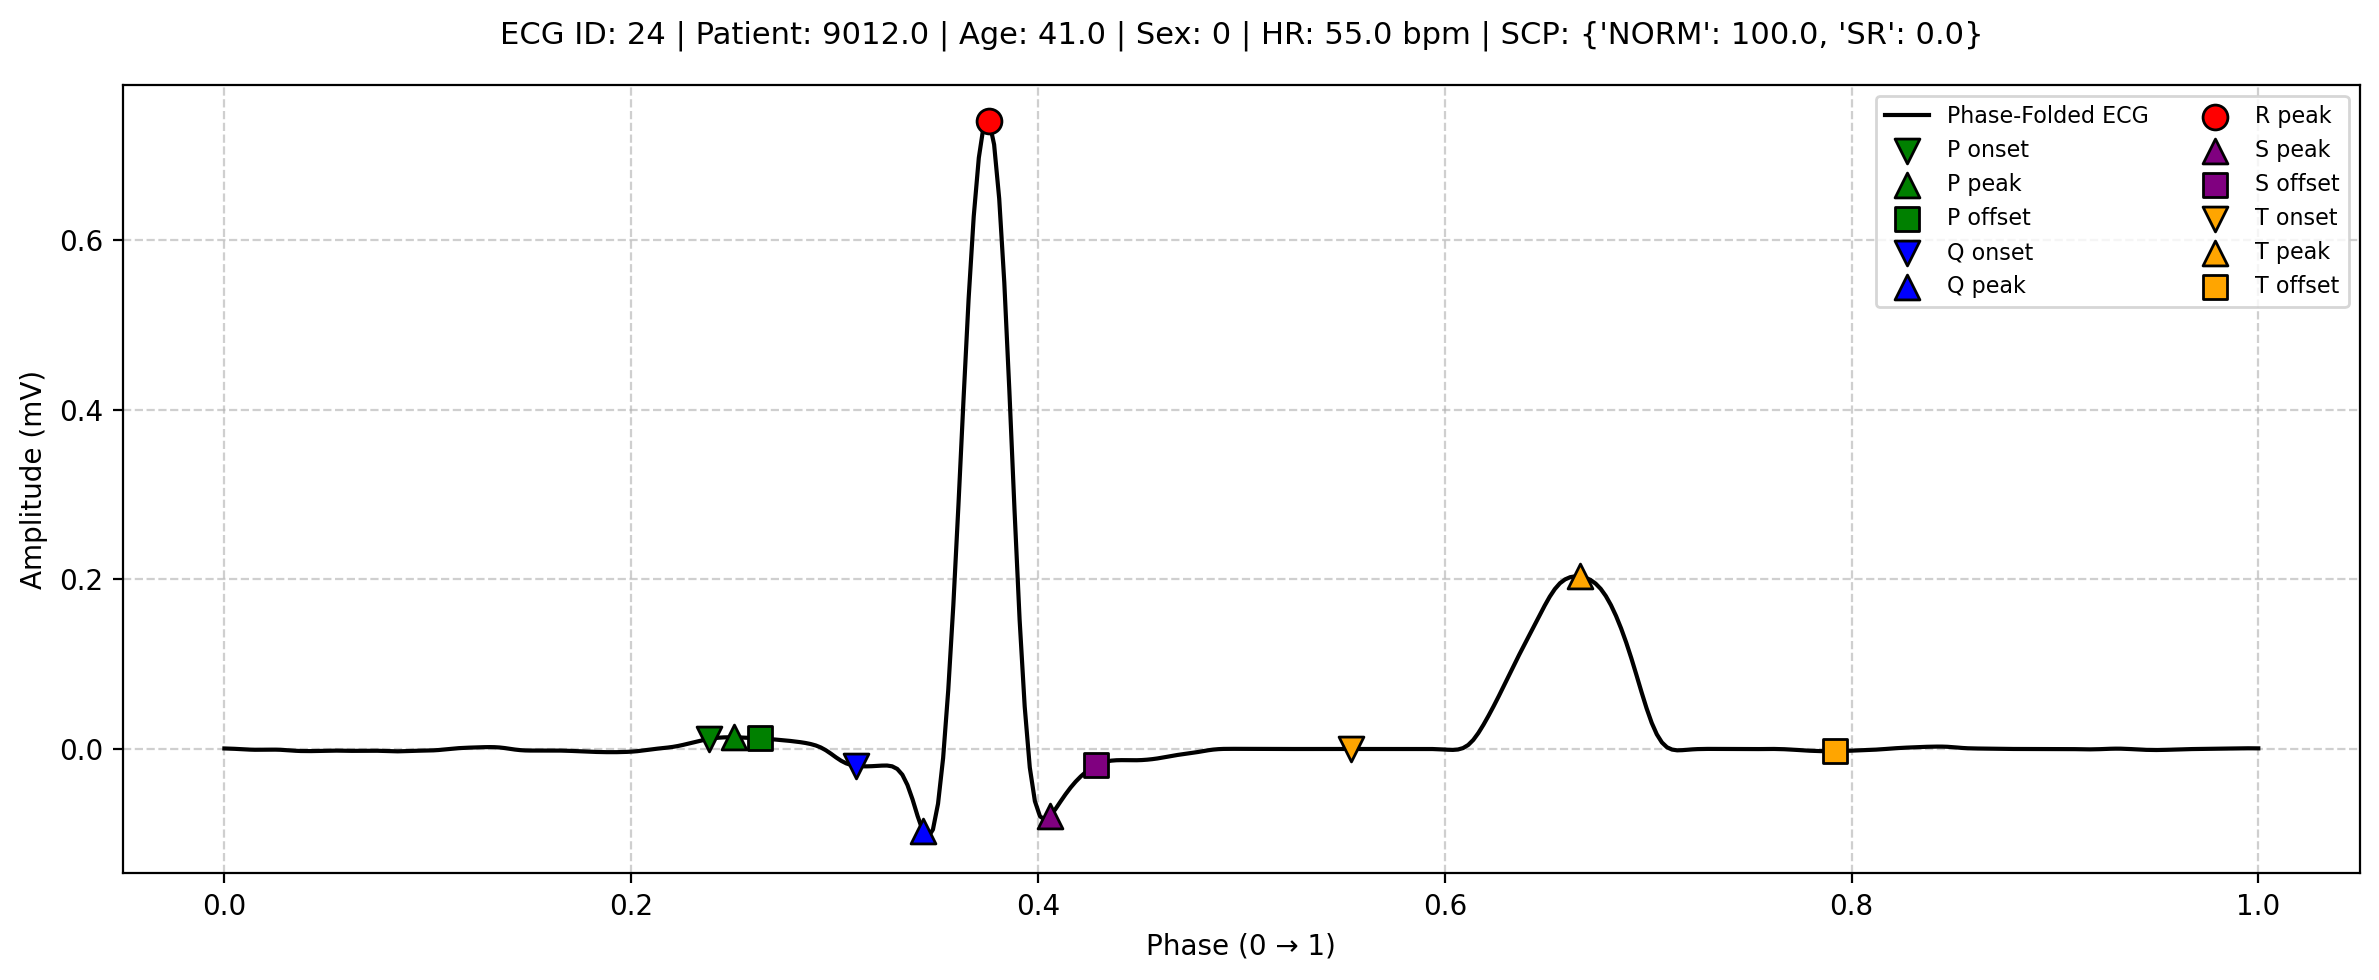

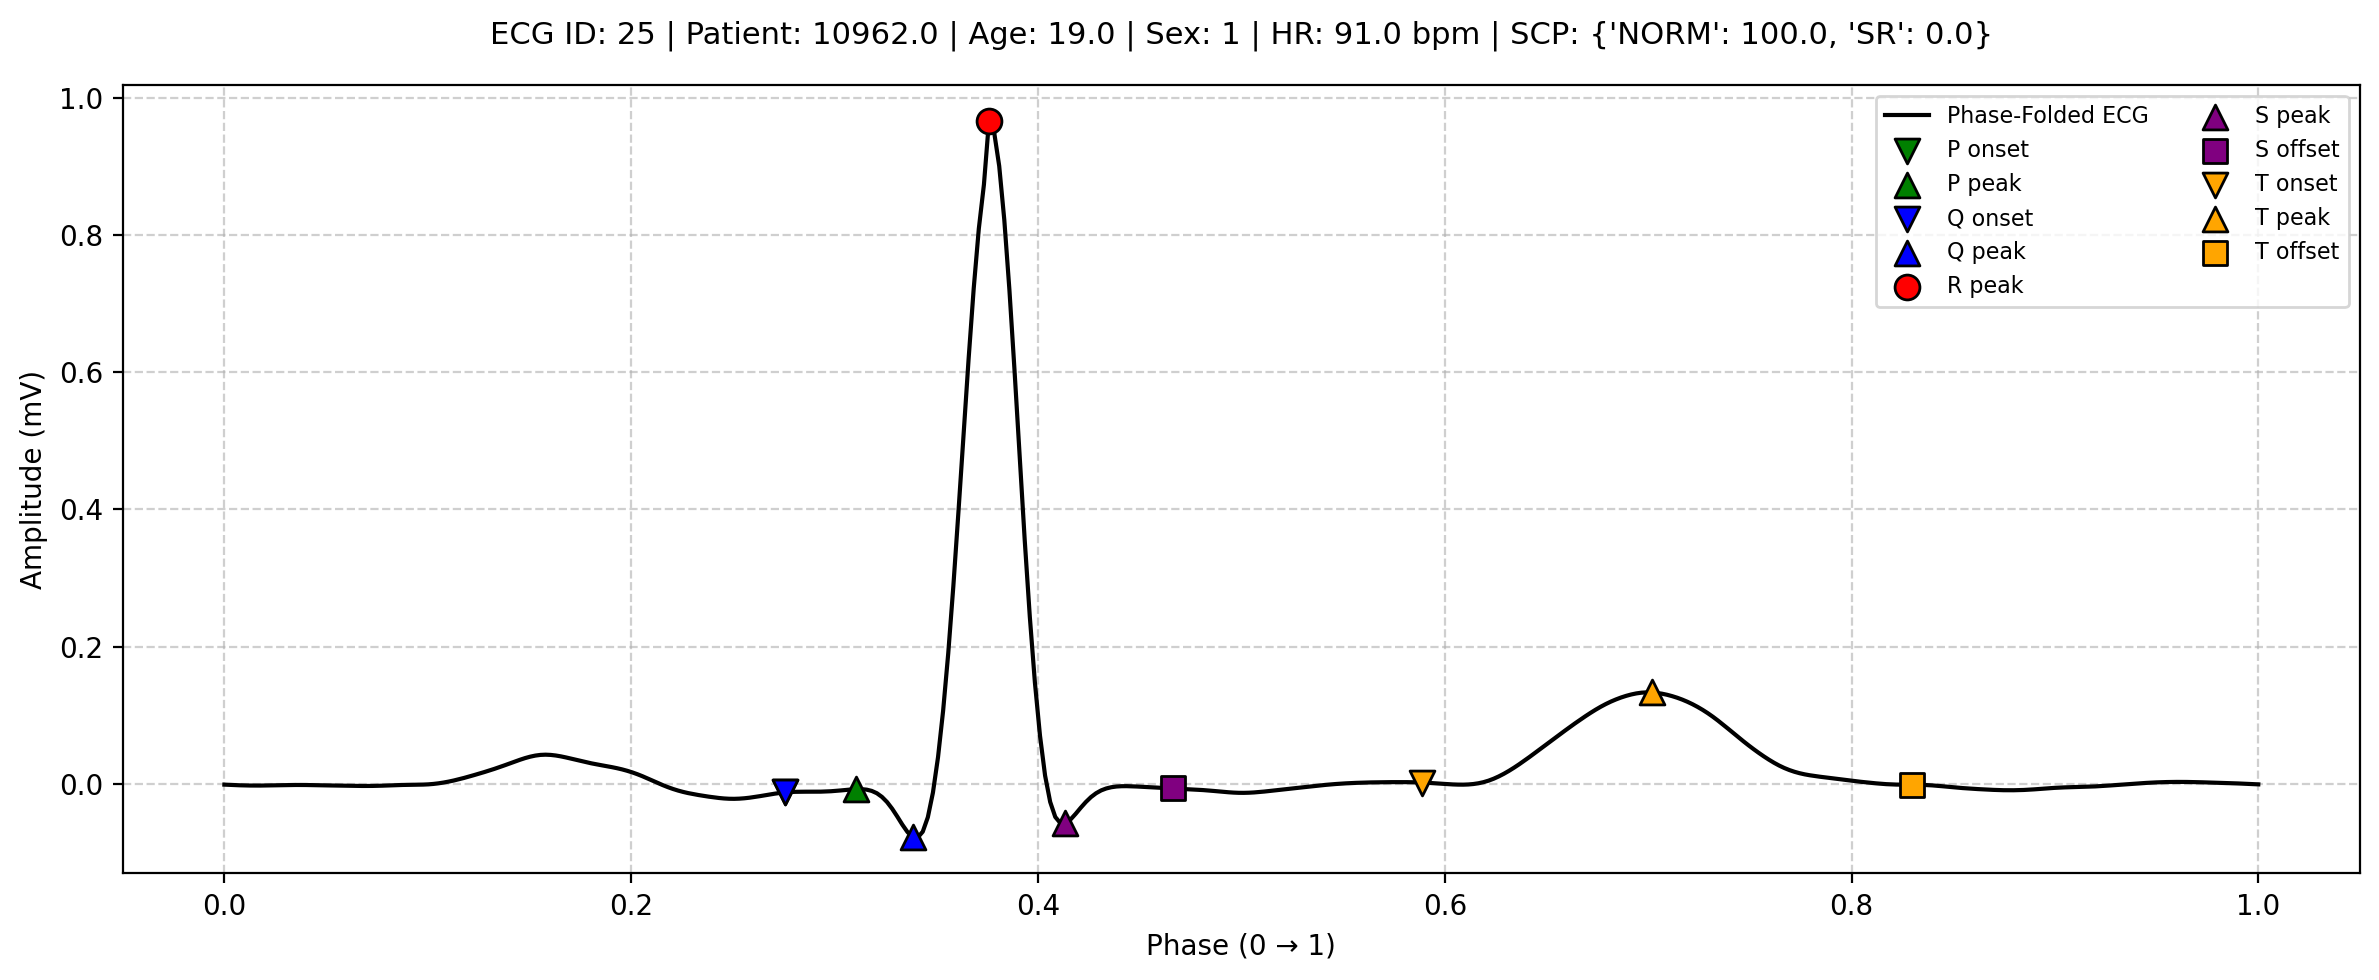

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
phase_folded_path = Path("/Users/rohanmotanavar/Dissertation ECG Parameterization/Pipeline3_Phase_Folding/phase_folded_results.h5")
features_path = Path("PQRST_Complexes_and_Features_final.h5")
normalized_length = 400
phase = np.linspace(0, 1, normalized_length)
sample_ecg_ids = ["21", "22", "24", "25"]

# Plotting
with h5py.File(phase_folded_path, 'r') as h5_phase, h5py.File(features_path, 'r') as h5_feat:
    for ecg_id in sample_ecg_ids:
        if ecg_id not in h5_phase or ecg_id not in h5_feat:
            print(f"Skipping ECG ID {ecg_id} — missing in one of the files.")
            continue

        beat = h5_phase[ecg_id]['representative_beat'][:]
        meta = h5_feat[ecg_id].attrs
        raw_points = h5_feat[ecg_id]['point_indices'][:]
        points = {name.decode('utf-8') if isinstance(name, bytes) else str(name): val for name, val in raw_points}

        wave_points = [
            ('p_on', 'P onset', 'green', 'v'),
            ('p_peak', 'P peak', 'green', '^'),
            ('p_off', 'P offset', 'green', 's'),
            ('q_on', 'Q onset', 'blue', 'v'),
            ('q_peak', 'Q peak', 'blue', '^'),
            ('r_peak', 'R peak', 'red', 'o'),
            ('s_peak', 'S peak', 'purple', '^'),
            ('s_off', 'S offset', 'purple', 's'),
            ('t_on', 'T onset', 'orange', 'v'),
            ('t_peak', 'T peak', 'orange', '^'),
            ('t_off', 'T offset', 'orange', 's'),
        ]

        plt.figure(figsize=(12, 5), dpi=200)
        plt.plot(phase, beat, label='Phase-Folded ECG', color='black', linewidth=1.5)

        for key, label, color, marker in wave_points:
            idx = points.get(key, np.nan)
            if not np.isnan(idx) and 0 <= int(idx) < normalized_length:
                plt.scatter(phase[int(idx)], beat[int(idx)], label=label, color=color,
                            marker=marker, s=80, edgecolors='k', zorder=3)

        title = (
            f"ECG ID: {ecg_id} | "
            f"Patient: {meta['patient_id']} | Age: {meta['age']} | Sex: {meta['sex']} | "
            f"HR: {meta['mean_heart_rate']:.1f} bpm | "
            f"SCP: {meta['scp_codes'].decode('utf-8') if isinstance(meta['scp_codes'], bytes) else meta['scp_codes']}"
        )
        plt.title(title, fontsize=11, pad=15)
        plt.xlabel("Phase (0 → 1)")
        plt.ylabel("Amplitude (mV)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=8, loc='upper right', ncol=2)
        plt.tight_layout()
        plt.savefig(f"ecg_plot_{ecg_id}.png")
        plt.show()
